# Word2Vec (Skipgram )

### Importing Library

In [4]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import json 
import time
import string

In [2]:
np.__version__, torch.__version__

('1.25.2', '2.1.1+cpu')

In [3]:
matplotlib.__version__

'3.7.2'

## 1. Load data and download resources

In [7]:
import nltk
# Download NLTK resources: 'reuters' corpus for text classification and 'punkt' tokenizer model for sentence splitting.

nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# Assigning NLTK's Reuters corpus sentences to 'corpus_reuters' for further processing.
corpus_reuters = reuters.sents()

In [10]:
# Joining each sentence in 'corpus_reuters' into a single string and tokenizing it into words, converting them to lowercase.
corpus_reuters = [" ".join(sent) for sent in corpus_reuters]
corpus_reuters = [nltk.word_tokenize(sent.lower()) for sent in corpus_reuters]

In [11]:
# Defining a lambda function 'flatten' to flatten a list of lists.
flatten = lambda l: [item for sublist in l for item in sublist]

# Calculating the total number of tokens in the 'corpus_reuters' by summing the lengths of all sentences.
total_tokens = sum(len(sentence) for sentence in corpus_reuters)


In [12]:
# Printing the total number of passages and tokens in the corpus_reuters.
print("Total Passages in the corpus:", len(corpus_reuters))
print("Total Tokens in the corpus:", total_tokens)


Total Passages in the corpus: 54716
Total Tokens in the corpus: 1728932


In [13]:
# Subset of 1000 passages created for efficiency, testing, resource constraints, and concise example demonstration.
corpus_ss = corpus_reuters[:1000]

In [14]:
# Defining a lambda function 'flatten' to flatten a list of lists and creating a vocabulary list.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_ss)))  # 'corpus_ss' contains tokenized sentences

In [15]:
#append UNK
vocabs.append('<UNK>')

In [20]:
vocabs[:5]

['bundey', 'cayb', 'ettore', 'sterivet', 'hackensack']

In [19]:
len(corpus_ss), len(vocabs)

(1000, 4153)

In [21]:
# Creating word to index and index to word dictionaries
word2index = {v: idx for idx, v in enumerate(vocabs)}
# Adding '<UNK>' token to word2index
word2index['<UNK>'] = len(vocabs) - 1

# Creating index to word dictionary
index2word = {v: k for k, v in word2index.items()}

# Calculating lengths of dictionaries
len(word2index), len(index2word)


(4153, 4153)

## 2. Prepare train data

In [22]:
corpus = corpus_ss # for simiplicity of operation 

def random_batch(batch_size, corpus, window_size=2):
    """
    Generates a random batch of skipgram pairs from a given corpus.

    Args:
    - batch_size: Number of skipgram pairs to include in the batch.
    - corpus: List of tokenized sentences forming the corpus.
    - window_size: Size of the context window to consider around each center word.

    Returns:
    - inputs: Array of center words.
    - labels: Array of corresponding outside words.
    """
    skipgrams = []  # List to store skipgram pairs

    # Loop over each document in the corpus
    for doc in corpus:
        # Look from the 2nd word until second last word
        for i in range(window_size, len(doc) - window_size):
            # Center word
            center = word2index.get(doc[i], word2index['<UNK>'])
            # Outside words (context words)
            outside = [word2index.get(doc[j], word2index['<UNK>']) for j in range(i - window_size, i + window_size + 1) if j != i]
            # For each outside word, create a skipgram pair with the center word
            for each_out in outside:
                skipgrams.append([center, each_out])

    # Randomly select skipgram pairs to form a batch
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    
    # Initialize lists to store inputs (center words) and labels (outside words)
    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])
        
    return np.array(inputs), np.array(labels)
            
# Example usage: Generating a random batch of 2 samples
x, y = random_batch(2, corpus)


In [23]:
x.shape  #batch_size, 1

(2, 1)

In [24]:
x

array([[2497],
       [2877]])

In [25]:
y.shape  #batch_size 1

(2, 1)

## 3. Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

In [26]:
import torch
import torch.nn as nn

class Skipgram(nn.Module):
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        # Define embeddings for center and outside words
        self.embedding_center = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)

    def forward(self, center, outside, all_vocabs):
        # Get embeddings for center and outside words
        center_embedding = self.embedding_center(center)  # (batch_size, 1, emb_size)
        outside_embedding = self.embedding_outside(outside)  # (batch_size, 1, emb_size)
        all_vocabs_embedding = self.embedding_center(all_vocabs)  # (batch_size, voc_size, emb_size)

        # Compute numerator of loss (dot product of outside and center embeddings)
        top_term = torch.exp(outside_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2))

        # Compute denominator of loss (dot product of all vocabulary embeddings and center embedding)
        lower_term = all_vocabs_embedding.bmm(center_embedding.transpose(1, 2)).squeeze(2)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1)  # Sum over vocabulary size to get denominator

        # Compute loss
        loss = -torch.mean(torch.log(top_term / lower_term_sum))  # Cross-entropy loss

        return loss


In [28]:
# Define the batch size and vocabulary size
batch_size = 2
voc_size = len(vocabs)

# Define a function to prepare a sequence
def prepare_sequence(seq, word2index):
    idxs = [word2index.get(w, word2index['<UNK>']) for w in seq]
    return torch.LongTensor(idxs)

# Convert the list of vocabs into indices using the word2index dictionary
all_vocabs = prepare_sequence(list(vocabs), word2index)

# Expand the tensor to match the batch size
all_vocabs = all_vocabs.unsqueeze(0).expand(batch_size, -1)

# Display the tensor
all_vocabs


tensor([[   0,    1,    2,  ..., 4150, 4151, 4152],
        [   0,    1,    2,  ..., 4150, 4151, 4152]])

In [29]:
model = Skipgram(voc_size, 2)
model

Skipgram(
  (embedding_center): Embedding(4153, 2)
  (embedding_outside): Embedding(4153, 2)
)

In [30]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [31]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [32]:
loss

tensor(9.7209, grad_fn=<NegBackward0>)

## 4. Training

In [33]:
import torch.optim as optim

# Define batch size, embedding size, and vocabulary size
batch_size = 2
emb_size = 2
voc_size = len(vocabs)

# Prepare all vocabulary indices for the given batch size
all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)

# Instantiate the Skipgram model with vocabulary size and embedding size
model = Skipgram(voc_size, emb_size)

# Instantiate the Adam optimizer with model parameters and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [35]:
import time

num_epochs = 10000
total_training_time = 0

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for current epoch
    
    # Get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    # Predict
    loss = model(input_tensor, label_tensor, all_vocabs)
    
    # Backpropagate
    optimizer.zero_grad()
    loss.backward()
    
    # Update model parameters
    optimizer.step()
    
    end_time = time.time()  # Record end time for current epoch
    epoch_time = end_time - start_time  # Calculate training time for current epoch
    total_training_time += epoch_time  # Accumulate training time for all epochs
    
    # Print the loss and epoch time
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss.item():2.6f} | Epoch Time: {epoch_time:.2f} seconds")

average_training_time_per_epoch = total_training_time / num_epochs
print(f"\nAverage Training Time per Epoch: {average_training_time_per_epoch:.2f} seconds")
print(f"Total Training Time for {num_epochs} Epochs: {total_training_time:.2f} seconds")


Epoch   1000 | Loss: 8.268476 | Epoch Time: 0.21 seconds
Epoch   2000 | Loss: 7.977573 | Epoch Time: 0.22 seconds
Epoch   3000 | Loss: 7.888247 | Epoch Time: 0.21 seconds
Epoch   4000 | Loss: 8.982678 | Epoch Time: 0.22 seconds
Epoch   5000 | Loss: 7.568085 | Epoch Time: 0.21 seconds
Epoch   6000 | Loss: 7.224583 | Epoch Time: 0.21 seconds
Epoch   7000 | Loss: 7.783993 | Epoch Time: 0.22 seconds
Epoch   8000 | Loss: 8.473045 | Epoch Time: 0.21 seconds
Epoch   9000 | Loss: 8.859234 | Epoch Time: 0.21 seconds
Epoch  10000 | Loss: 8.745810 | Epoch Time: 0.23 seconds

Average Training Time per Epoch: 0.18 seconds
Total Training Time for 10000 Epochs: 1836.59 seconds


In [36]:
total_training_time_minutes = total_training_time / 60  # Convert total training time to minutes
print(f"Total Training Time for {num_epochs} Epochs: {total_training_time_minutes:.2f} minutes")

Total Training Time for 10000 Epochs: 30.61 minutes


## 5. Plot the embeddings


In [37]:
def get_embed(word):
    try:
        index = word2index[word]  # Get the index of the word from word2index dictionary
    except KeyError:
        index = word2index['<UNK>']  # If word is not found, use index for '<UNK>' token
    
    word_tensor = torch.LongTensor([index])  # Convert index to tensor
    
    # Get embeddings for center and outside words
    embed_c = model.embedding_center(word_tensor)
    embed_o = model.embedding_outside(word_tensor)
    
    # Compute average embedding
    embed = (embed_c + embed_o) / 2
    
    # Return the embedding as a tuple of two values (embedding dimensions)
    return embed[0][0].item(), embed[0][1].item()


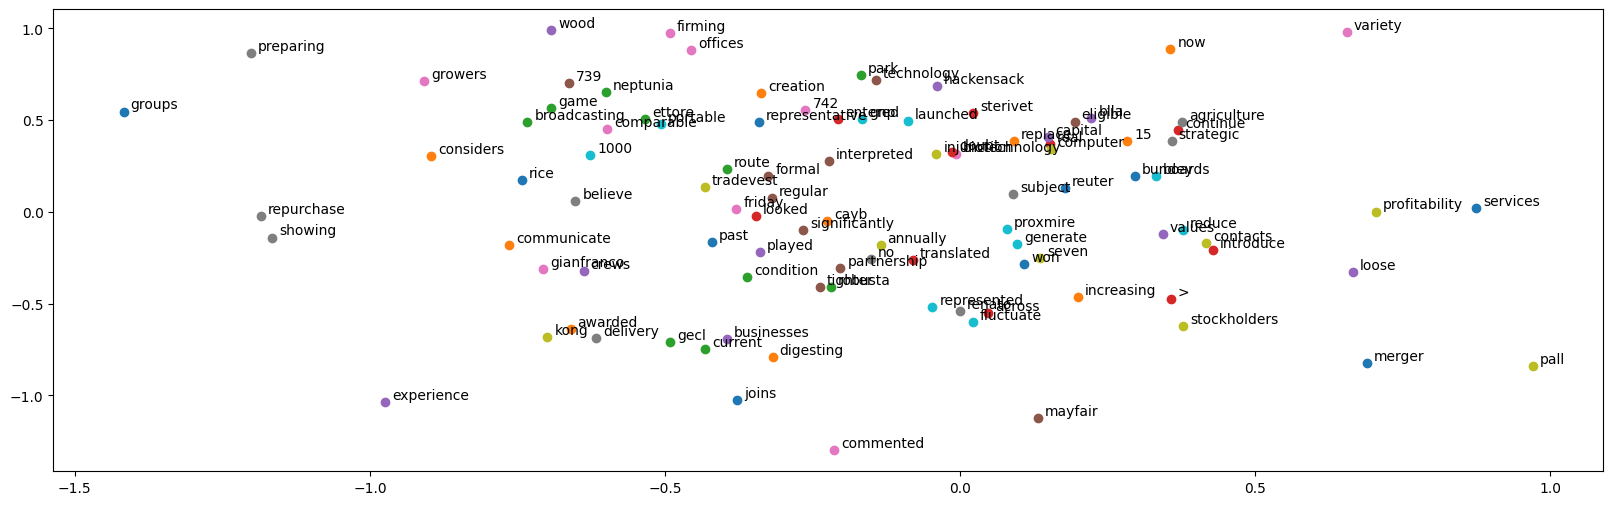

In [40]:
plt.figure(figsize=(20, 6))
for i, word in enumerate(vocabs[:100]):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

In [41]:
game = get_embed('game')
game

(-0.6928703784942627, 0.5652516484260559)

In [42]:
broadcasting = get_embed('broadcasting')
broadcasting

(-0.7332843542098999, 0.4874322712421417)

In [43]:
unk = get_embed('<UNK>')
unk

(0.4392901062965393, 0.15337315201759338)

In [44]:
np.array(game) @ np.array(unk)

-0.21767667521622336

In [45]:
np.array(game) @ np.array(broadcasting)

0.7835929028610114

In [48]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(game), np.array(unk)))
print(cosine_similarity(np.array(game), np.array(broadcasting)))

-0.5231824827973933
0.9952359254584596


**Similarity between "game" and unk :**

Dot product: -0.21767667521622336
Cosine similarity: -0.5231824827973933


Both the dot product and cosine similarity indicate a negative value, suggesting that the direction of the embeddings is somewhat opposite or dissimilar.

The cosine similarity value is -0.523, indicating a moderate level of dissimilarity between "game" and unk.

**Similarity between "game" and "broadcasting":**

Dot product: 0.7835929028610114
Cosine similarity: 0.9952359254584596

Both the dot product and cosine similarity indicate a positive value, suggesting that the direction of the embeddings is somewhat aligned or similar.

The cosine similarity value is 0.995, indicating a high level of similarity between "game" and "broadcasting".

## 7. Save

The purpose of saving the word2index and index2word dictionaries to JSON files is to preserve them for future use. These dictionaries contain mappings between words and their corresponding indices, and vice versa. 

In [49]:
word2index_path = './model/word2index_skipgram.json'  
index2word_path = './model/index2word_skipgram.json'  

with open(word2index_path, 'w') as file:
    json.dump(word2index, file)  

with open(index2word_path, 'w') as file:
    json.dump(index2word, file)  

In [52]:
# The purpose of saving the corpus is to preserve it for future use, 
# allowing easy access to the preprocessed text data without the need to tokenize again.corpus_path = './mode/corpus.txt'
corpus_path = './model/corpus.txt'

with open(corpus_path, 'w') as file:
    for sentence in corpus:
        # Join the tokens of the sentence into a single string with spaces and write it to the file
        file.write(' '.join(sentence) + '\n')


In [54]:
# Define the vocabulary size and embedding size
voc_size_w2i = len(word2index)
emb_size = emb_size  #  emb_size is previously defined in the code

# Define paths for saving model state and configuration
model_path = './model/word2vec_model_skipgram.pth'
config_path = './model/word2vec_config_skipgram.json'

# Save the model state to a file
torch.save(model.state_dict(), model_path)

# Save the model configuration to a JSON file
with open(config_path, 'w') as config_file:
    config = {'voc_size': voc_size_w2i , 'emb_size': emb_size}
    json.dump(config, config_file)

# Print messages indicating successful saving of model and configuration
print(f"Model saved to {model_path}")
print(f"Configuration saved to {config_path}")


Model saved to ./model/word2vec_model_skipgram.pth
Configuration saved to ./model/word2vec_config_skipgram.json


Model File (word2vec_model_skipgram.pth):

This file saves the state of the word2vec model. It includes the trained parameters of the model, such as weights and biases, which define the learned embeddings. Saving the model state allows you to load the trained model later for inference or further training without needing to retrain it from scratch.

Config File (word2vec_config_skipgram.json):

This file saves the configuration of the word2vec model. It typically includes important parameters or settings used during training, such as the vocabulary size (voc_size) and the embedding size (emb_size). Saving the model configuration allows you to reproduce the training setup and settings when loading the model for future use.

## 8. Inference 


In [61]:
import json

word2index_path = './model/word2index_skipgram.json'  # Path to the JSON file containing word-to-index mappings
index2word_path = './model/index2word_skipgram.json'  # Path to the JSON file containing index-to-word mappings

# Load word-to-index dictionary from JSON file
with open(word2index_path, 'r') as file:
    word2index = json.load(file)  # Load the word2index dictionary from the JSON file

# Load index-to-word dictionary from JSON file
with open(index2word_path, 'r') as file:
    index2word = json.load(file)  # Load the index2word dictionary from the JSON file

# Print loaded dictionaries
print("Word to Index Dictionary:")
print(word2index)
print("\nIndex to Word Dictionary:")
print(index2word)


Word to Index Dictionary:
{'bundey': 0, 'cayb': 1, 'ettore': 2, 'sterivet': 3, 'hackensack': 4, 'mayfair': 5, 'comparable': 6, 'delivery': 7, 'stockholders': 8, '1000': 9, 'groups': 10, 'now': 11, 'neptunia': 12, 'translated': 13, 'businesses': 14, 'eligible': 15, 'biotechnology': 16, 'repurchase': 17, 'pall': 18, 'fluctuate': 19, 'joins': 20, '15': 21, 'condition': 22, '>': 23, 'crews': 24, 'partnership': 25, 'friday': 26, 'showing': 27, 'annually': 28, 'launched': 29, 'rice': 30, 'considers': 31, 'broadcasting': 32, 'entered': 33, 'values': 34, 'significantly': 35, '742': 36, 'believe': 37, 'contacts': 38, 'boards': 39, 'won': 40, 'increasing': 41, 'park': 42, 'real': 43, 'loose': 44, 'regular': 45, 'variety': 46, 'no': 47, 'computer': 48, 'generate': 49, 'past': 50, 'digesting': 51, 'current': 52, 'looked': 53, 'capital': 54, 'technology': 55, 'growers': 56, 'subject': 57, 'seven': 58, 'gnp': 59, 'services': 60, 'replace': 61, 'route': 62, 'across': 63, 'wood': 64, 'interpreted': 65

In [66]:
path = './model/corpus.txt' 
def corpus_infer(path):
    corpus = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            if line:  
                corpus.append(line)
    return corpus

corpus = corpus_infer(path)


In [67]:
len(corpus)

1000

In [77]:
# Load the word2vec model and its configuration
def load_word2vec_model(model_path, config_path):
    """
    Load the pre-trained word2vec model and its configuration.

    Args:
    - model_path (str): Path to the file containing the model state.
    - config_path (str): Path to the file containing the model configuration.

    Returns:
    - loaded_model: The loaded word2vec model.
    - voc_size (int): The vocabulary size.
    - emb_size (int): The embedding size.
    """
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)
    voc_size = config['voc_size']
    emb_size = config['emb_size']

    # Initialize model
    loaded_model = Skipgram(voc_size, emb_size)
    
    # Load model state
    loaded_model.load_state_dict(torch.load(model_path))
    
    # Set model to evaluation mode
    loaded_model.eval()

    print("Model loaded")
    
    return loaded_model, voc_size, emb_size

# Preprocess the text
def tokenize_text(text):
    """
    Tokenize the input text into words.

    Args:
    - text (str): Input text to be tokenized.

    Returns:
    - tokens (list): List of tokens obtained from the input text.
    """
    tokens = nltk.word_tokenize(text.lower())
    return tokens

# Get the embedding for a given text
def get_text_embedding(text, model, word2index):
    """
    Get the embedding for a given text using the word2vec model.

    Args:
    - text (str): Input text.
    - model: Pre-trained word2vec model.
    - word2index (dict): Word-to-index mapping.

    Returns:
    - text_embedding (np.array): Embedding vector for the input text.
    """
    tokens = tokenize_text(text)
    embeddings = []

    for token in tokens:
        index = word2index.get(token, word2index.get('<UNK>'))
        word_tensor = torch.LongTensor([index])

        embed_center = model.embedding_center(word_tensor)
        embed_outside = model.embedding_outside(word_tensor)
        embed = (embed_center + embed_outside) / 2
        embeddings.append(embed.detach().numpy())
    
    if embeddings:
        embeddings = np.array(embeddings)
        text_embedding = np.mean(embeddings, axis=0)

    text_embedding = text_embedding.flatten()  # Flatten the array to ensure it's 1-D
    
    return text_embedding

# Retrieve top passages similar to the query
def find_similar_passages(query, corpus, model, word2index, top_n=20):
    """
    Find top passages similar to the input query from the corpus.

    Args:
    - query (str): Input query.
    - corpus (list): List of passages in the corpus.
    - model: Pre-trained word2vec model.
    - word2index (dict): Word-to-index mapping.
    - top_n (int): Number of top passages to retrieve.

    Returns:
    - top_passages (list): List of top passages along with their similarity scores.
    """
    # Convert query to embedding
    query_embedding = get_text_embedding(query, model, word2index)
    similarities = []

    # Compute similarity between query and each passage in corpus
    for passage in corpus:
        passage_embedding = get_text_embedding(passage, model, word2index)
        similarity = np.dot(query_embedding, passage_embedding)
        similarities.append(similarity)

    # Sort passages based on similarity scores
    sorted_indices = sorted(range(len(similarities)), key=lambda i: similarities[i], reverse=True)
    top_indices = sorted_indices[:top_n]

    # Retrieve top passages along with similarity scores
    top_passages = [(corpus[idx], (similarities[idx]) * 100) for idx in top_indices]
    
    return top_passages


# Load the word2vec model and its configuration
loaded_model, voc_size, emb_size = load_word2vec_model(model_path, config_path)

# Example usage with a different query
new_query = "the analysts agreed the bank was aggressive"
print('Search query: ', new_query)
top_passages = find_similar_passages(new_query, corpus, loaded_model, word2index, top_n=20)
i = 1
print("Top Similar Passages with similarity score")
for passage, score in top_passages:
    print(i, passage,'\t\t\t\t\t\t', score)
    i += 1

Model loaded
Search query:  the analysts agreed the bank was aggressive
Top Similar Passages with similarity score
1 `` but everything is on hold now . '' 						 51.292020082473755
2 the u . s . 						 42.46954619884491
3 the analysts agreed the bank was aggressive . 						 42.30036437511444
4 `` u . s . 						 39.022791385650635
5 the new shares will rank for dividends declared after october 31 . 						 36.34266257286072
6 `` we are aware of the seriousness of the u . s . 						 35.466501116752625
7 the shares later eased back to 481p . 						 33.07687044143677
8 cojuangco said the coconut industry investment fund ( ciif ) and 1 . 4 mln farmers were the rightful owners of the shares . 						 32.93909728527069
9 an indication of the u . s . 						 31.034982204437256
10 today the company reported first quarter earnings of 20 . 6 mln dlrs on sales of 238 . 0 mln dlrs , up from earnings of 16 . 1 mln dlrs on sales of 188 . 8 mln dlrs . 						 29.781296849250793
11 `` the u . s . has exces